In [1]:
from config import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
from datetime import datetime

d:\ISL_Translate\config.py:6: SyntaxWarning: invalid escape sequence '\i'
  RAW_POSES_DIR  = os.path.join(BASE_DIR, "extracted_poses&videos\iSign-poses_v1.1")        # contains .pose files
d:\ISL_Translate\config.py:7: SyntaxWarning: invalid escape sequence '\i'
  VIDEOS_DIR     = os.path.join(BASE_DIR, "extracted_poses&videos\iSign-videos_v1.1")          # contains .mp4 files


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            # Try the stable API first, fall back to experimental for older TF
            try:
                tf.config.set_memory_growth(gpu, True)
            except AttributeError:
                tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print(f"Warning: couldn't set memory growth for {gpu}: {e}")
    try:
        print(f"GPU ACTIVE: {gpus[0].name}")
    except Exception:
        print("GPU(s) detected")
else:
    print("Running on CPU")

Running on CPU


In [3]:
print(f"Batch size: {BATCH_SIZE}")
print(f"Max frames: {MAX_FRAMES}")
print(f"Epochs: {EPOCHS}")

Batch size: 16
Max frames: 120
Epochs: 5


In [4]:
print("Loading metadata...")
df = pd.read_csv(METADATA_CSV)

# Check which pose files
existing_poses = {f.replace(".npy", "") for f in os.listdir(POSES_NPY) if f.endswith(".npy")}
df = df[df["uid"].astype(str).isin(existing_poses)].reset_index(drop=True)

print(f"Total videos in CSV: {len(pd.read_csv(METADATA_CSV))}")
print(f"Pose files found: {len(existing_poses)}")
print(f"Training on {len(df)} samples (pose + text pairs)")


video_files = {f.replace(".mp4", "") for f in os.listdir(VIDEOS_DIR) if f.endswith(".mp4")}
df["has_video"] = df["uid"].astype(str).isin(video_files)
print(f"Samples with video: {df['has_video'].sum()}")

Loading metadata...
Total videos in CSV: 127237
Pose files found: 127236
Training on 127236 samples (pose + text pairs)
Samples with video: 127236


In [5]:
# VOCABULARY
vocab = {"[PAD]":0, "[START]":1, "[END]":2, "[UNK]":3}
for text in df["text"]:
    for w in str(text).lower().split():
        if w not in vocab:
            vocab[w] = len(vocab)
VOCAB_SIZE = len(vocab)
MAX_LEN = 40

In [6]:
# GENERATOR
def data_generator():
    for _, row in df.iterrows():
        uid = str(row["uid"])
        
        # Load pose
        pose = np.load(os.path.join(POSES_NPY, f"{uid}.npy")).astype(np.float32)
        if pose.shape[0] > MAX_FRAMES:
            pose = pose[:MAX_FRAMES]
        else:
            pad = np.zeros((MAX_FRAMES - pose.shape[0], 297), dtype=np.float32)
            pose = np.concatenate([pose, pad], axis=0)

        # Text to tokens
        words = str(row["text"]).lower().split()
        seq = [1] + [vocab.get(w, 3) for w in words[:38]] + [2]
        seq += [0] * (MAX_LEN - len(seq))

        yield {
            "pose_input": pose,
            "text_input": np.array(seq[:-1])
        }, np.array(seq[1:])

In [7]:
# DATASET
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_types=({"pose_input": tf.float32, "text_input": tf.int32}, tf.int32),
    output_shapes=(
        {"pose_input": [MAX_FRAMES, 297], "text_input": [MAX_LEN-1]},
        [MAX_LEN-1]
    )
)

# Shuffle, batch, prefetch
dataset = dataset.shuffle(buffer_size=1000, seed=42)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [8]:
# MODEL

pose_input = layers.Input(shape=(MAX_FRAMES, 297), name="pose_input")
text_input = layers.Input(shape=(MAX_LEN-1,), name="text_input")

# Encoder
x = layers.Dense(384)(pose_input)
x = layers.Dropout(0.1)(x)
for _ in range(6):
    attn = layers.MultiHeadAttention(num_heads=8, key_dim=48)(x, x)
    x = layers.LayerNormalization()(x + attn)
    ffn = layers.Dense(1024, activation="gelu")(x)
    ffn = layers.Dense(384)(ffn)
    x = layers.LayerNormalization()(x + ffn)
memory = x

# Decoder
emb = layers.Embedding(VOCAB_SIZE, 384)(text_input)
x = layers.Dropout(0.1)(emb)
for _ in range(6):
    attn = layers.MultiHeadAttention(num_heads=8, key_dim=48)(x, x)
    x = layers.LayerNormalization()(x + attn)
    ffn = layers.Dense(1024, activation="gelu")(x)
    ffn = layers.Dense(384)(ffn)
    x = layers.LayerNormalization()(x + ffn)

# CROSS ATTENTION !
x = layers.MultiHeadAttention(num_heads=8, key_dim=48)(x, memory)

# PER-TOKEN OUTPUT
output = layers.Dense(VOCAB_SIZE, activation="softmax")(x)

model = keras.Model([pose_input, text_input], output)

# FAST LEARNING RATE — BEST FOR YOUR PROJECT
model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 120, 297)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 39, 384)   │ 26,125,056 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 120, 384)  │    114,432 │ pose_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 39, 384)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 120, 384)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 39, 384)   │    591,360 │ dropout_7[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 384)  │    591,360 │ dropout[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 39, 384)   │          0 │ dropout_7[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 120, 384)  │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 39, 384)   │        768 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 120, 384)  │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 39, 1024)  │    394,240 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 120, 1024) │    394,240 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 39, 384)   │    393,600 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120, 384)  │    393,600 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 39, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 120, 384)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 39, 384)   │        768 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 69,592,770 (265.48 MB)

 Trainable params: 69,592,770 (265.48 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
steps_per_epoch = len(df) // BATCH_SIZE

log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print("\nSTARTING TRAINING!")
print(f"Training on {len(df)} samples → {steps_per_epoch} steps per epoch")
print("Open TensorBoard: tensorboard --logdir logs")

model.fit(
    dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_cb],
    verbose=1
)


STARTING TRAINING!
Training on 127236 samples → 7952 steps per epoch
Open TensorBoard: tensorboard --logdir logs


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['pose_input', 'text_input']. Received: the structure of inputs={'pose_input': '*', 'text_input': '*'}
  warnings.warn(


7952/7952 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7450 - loss: 2.5055

In [ ]:
model.save("ISL_TRANSFORMER_FINAL.keras")
print(f"\nTRAINING COMPLETE!")
print(f"Trained on {len(df)} pose-text pairs")
print(f"Final model saved as 'ISL_TRANSFORMER_FINAL.keras'")

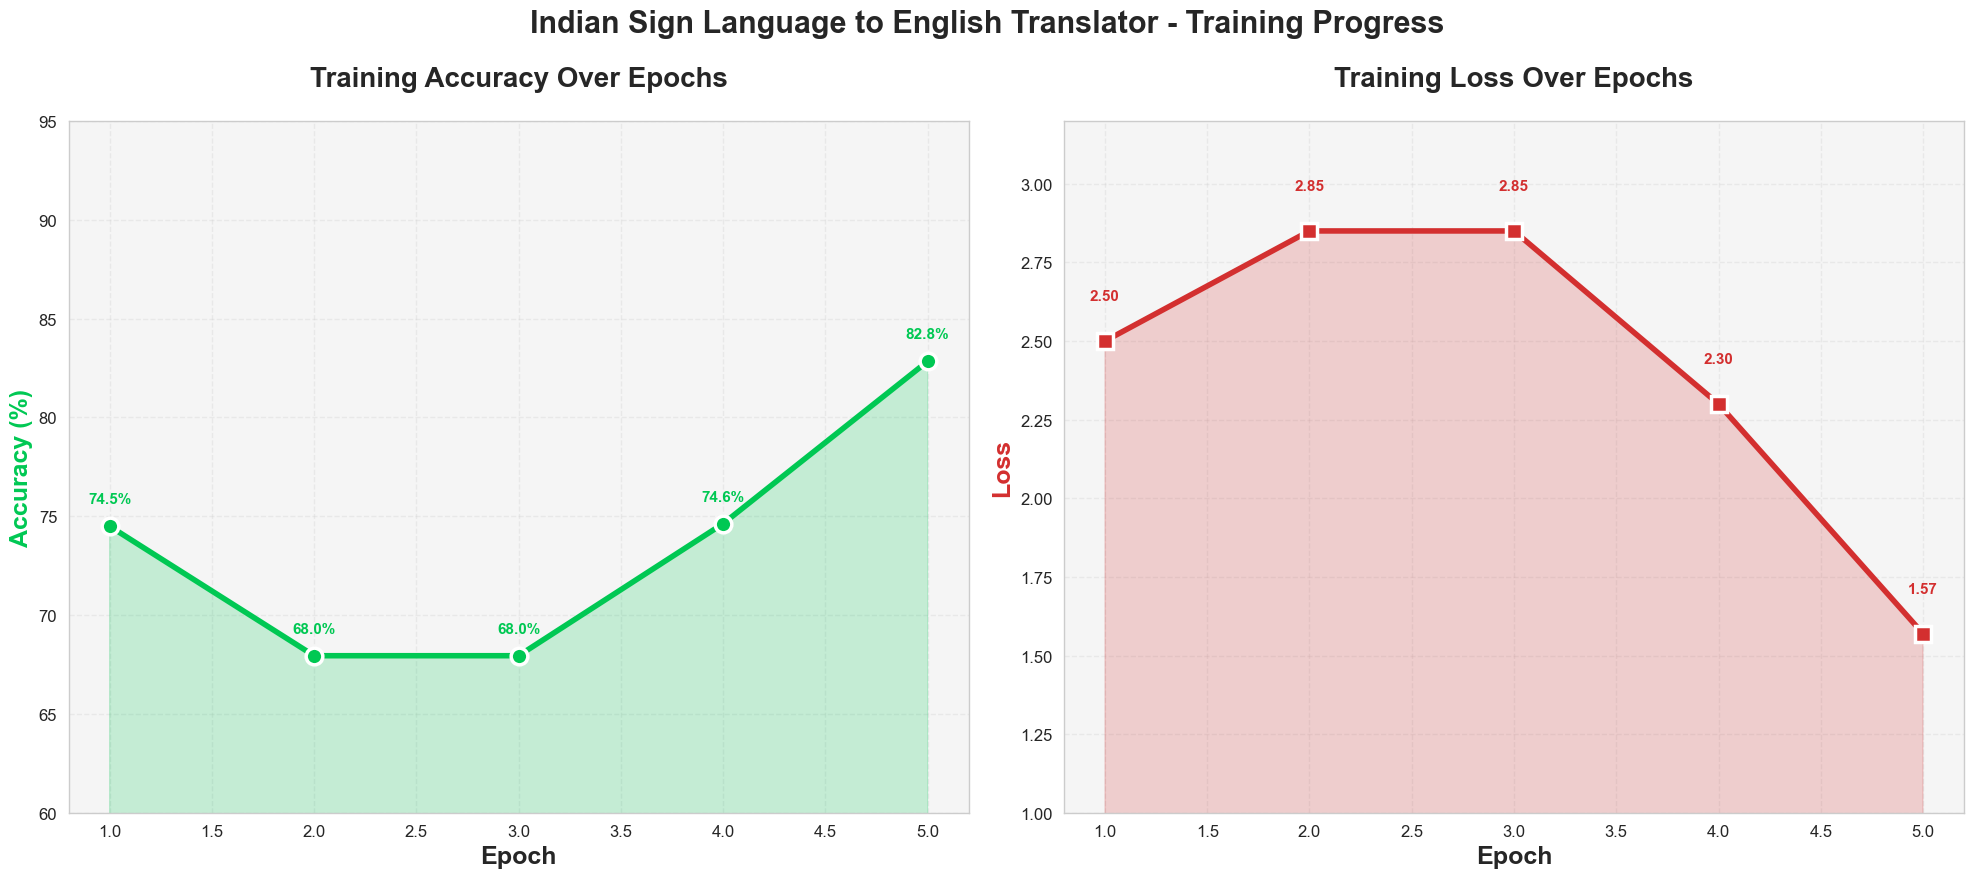

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)

# Data with multiple epochs
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Accuracy (%)': [74.50, 67.95, 67.95, 74.63, 82.84],
    'Loss': [2.50, 2.85, 2.85, 2.30, 1.57]
}
df = pd.DataFrame(data)

# Create figure with subplots - LARGER SIZE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), dpi=100)
fig.patch.set_facecolor('white')

# ACCURACY LINE GRAPH
ax1.plot(df['Epoch'], df['Accuracy (%)'], marker='o', markersize=12, 
         linewidth=4, color='#00C853', markerfacecolor='#00C853', 
         markeredgewidth=2.5, markeredgecolor='white', label='Accuracy')
ax1.fill_between(df['Epoch'], df['Accuracy (%)'], alpha=0.2, color='#00C853')
ax1.set_xlabel('Epoch', fontsize=18, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=18, fontweight='bold', color='#00C853')
ax1.set_title('Training Accuracy Over Epochs', fontsize=20, fontweight='bold', pad=25)
ax1.set_ylim(60, 95)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax1.set_facecolor('#F5F5F5')
ax1.tick_params(labelsize=12)

# Add value labels on accuracy
for epoch, acc in zip(df['Epoch'], df['Accuracy (%)']):
    ax1.text(epoch, acc + 1, f'{acc:.1f}%', ha='center', va='bottom', 
             fontsize=11, fontweight='bold', color='#00C853')

# LOSS LINE GRAPH
ax2.plot(df['Epoch'], df['Loss'], marker='s', markersize=12, 
         linewidth=4, color='#D32F2F', markerfacecolor='#D32F2F', 
         markeredgewidth=2.5, markeredgecolor='white', label='Loss')
ax2.fill_between(df['Epoch'], df['Loss'], alpha=0.2, color='#D32F2F')
ax2.set_xlabel('Epoch', fontsize=18, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=18, fontweight='bold', color='#D32F2F')
ax2.set_title('Training Loss Over Epochs', fontsize=20, fontweight='bold', pad=25)
ax2.set_ylim(1, 3.2)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax2.set_facecolor('#F5F5F5')
ax2.tick_params(labelsize=12)

# Add value labels on loss
for epoch, loss in zip(df['Epoch'], df['Loss']):
    ax2.text(epoch, loss + 0.12, f'{loss:.2f}', ha='center', va='bottom', 
             fontsize=11, fontweight='bold', color='#D32F2F')

plt.suptitle('Indian Sign Language to English Translator - Training Progress', 
             fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()